## Import packages

In [1]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene, bartlett
from scipy.stats import mannwhitneyu
import pandas as pd
from scipy.stats import ttest_ind
import Levenshtein
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

In [2]:
def ConhenD(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1, ddof=1)  # 使用Bessel校正
    std2 = np.std(group2, ddof=1)

    # 计算Cohen's d
    pooled_std = np.sqrt(((len(group1)-1) * std1**2 + (len(group2)-1) * std2**2) / (len(group1) + len(group2) - 2))
    cohen_d = (mean1 - mean2) / pooled_std

    print("Cohen's d:", cohen_d)


def diff_analysis(vector1, vector2):
    # 进行Levene方差比较检验
    statistic, p_value_var = levene(vector1, vector2)

    print("Levene's test statistic for variance comparison:", statistic)
    print("P-value for variance comparison:", p_value_var)
    equal_var = None
    # 根据方差比较结果选择t检验方法
    if p_value_var < 0.05:
        ttest_method = 'Mann-Whitney U'
        equal_var = False  # 使用 Mann-Whitney U
    else:
        ttest_method = 'Student'
        equal_var = True   # 使用Student's t-test
    statistic = None
    p_value = None
    # 进行t检验
    if equal_var:
        statistic, p_value = ttest_ind(vector1, vector2, equal_var=equal_var)
    else:
        statistic, p_value = mannwhitneyu(vector1, vector2)
    print(f"The statistical value of t test is STA: {statistic} and p_value: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis using {ttest_method}'s t-test: There is a significant difference between the two vectors.")
    else:
        print(f"Fail to reject the null hypothesis using {ttest_method}'s t-test: There is no significant difference between the two vectors.")

def draw_box(vector1, vector2, name = "default"):
    # 使用Seaborn绘制核密度估计图
    # 将两组数据放在一个列表中
    data = [vector1, vector2]
    # 绘制并列箱型图
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=['Control group', 'Experiment group'])
    plt.ylabel('Value')
    plt.title(name)
    plt.show()

def draw_kde_BLOCK(array1, array2, array3, array4, name = "default"):
    # 创建一个包含两个子图的大图
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 绘制左边的KDE图
    sns.kdeplot(array1, label='Control group', ax=axes[0], fill=True)
    sns.kdeplot(array2, label='Experiment group', ax=axes[0], fill=True)
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('TYPE 0: IMPORTANT ITEM')
    axes[0].legend()
    axes[0].set_xlim(-1, 3)
    # 绘制右边的KDE图
    sns.kdeplot(array3, label='Control group', ax=axes[1], fill=True)
    sns.kdeplot(array4, label='Experiment group', ax=axes[1], fill=True)
    axes[1].set_xlabel('Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('TYPE 1: SMALL ITEM')
    axes[1].legend()
    axes[1].set_xlim(-1, 3)
    # 调整子图之间的间距
    plt.tight_layout()
    
    
    # 显示图形
    plt.show()
    
def array_variable_diff(LIKE, REMEMBER, LOCATION, ORIENTATION, name = "default"):
    # 正态性检验（Shapiro-Wilk测试）
    def perform_shapiro_test(data):
        stat, p = stats.shapiro(data)
        return p

    # 方差齐性检验（Levene测试）
    def perform_levene_test(*data_arrays):
        stat, p = stats.levene(*data_arrays)
        return p

    # 多因素ANOVA
    def perform_anova(*data_arrays):
        f_statistic, p_value = f_oneway(*data_arrays)
        return p_value

    # 执行正态性检验
    p_like = perform_shapiro_test(LIKE)
    p_remember = perform_shapiro_test(REMEMBER)
    p_location = perform_shapiro_test(LOCATION)
    p_orientation = perform_shapiro_test(ORIENTATION)

    print("正态性检验结果:")
    print("喜好程度:", p_like)
    print("辅助记忆区域:", p_remember)
    print("辅助定位:", p_location)
    print("辅助认知朝向:", p_orientation)
    # 执行方差齐性检验
    p_levene = perform_levene_test(LIKE, REMEMBER, LOCATION, ORIENTATION)

    print("\n方差齐性检验结果:")
    print("Levene检验p值:", p_levene)

    # 执行多因素ANOVA
    p_anova = perform_anova(LIKE, REMEMBER, LOCATION, ORIENTATION)

    print("\n多因素ANOVA结果:")
    print("ANOVA p值:", p_anova)

    # 判断是否进行事后分析
    if p_anova < 0.05:
        print("\n存在显著差异，可以进行事后分析。")
    else:
        print("\n各方面评分没有显著差异。")


    # 将数据组合成一个单独的数组，以便进行事后分析
    all_data = np.concatenate([LIKE, REMEMBER, LOCATION, ORIENTATION])
    labels = ['PREFERENCE'] * len(LIKE) + ['MEMORY'] * len(REMEMBER) + ['LOCATING'] * len(LOCATION) + ['ORIENTATION'] * len(ORIENTATION)

    # 进行Tukey HSD事后分析
    result = pairwise_tukeyhsd(all_data, labels, 0.05)
    print(result._results_table)
    result.plot_simultaneous()
    plt.title(name)
    plt.xlabel("Score")
    plt.show()

    # 计算平均分数
    average_like = sum(LIKE) / len(LIKE)
    average_remember = sum(REMEMBER) / len(REMEMBER)
    average_location = sum(LOCATION) / len(LOCATION)
    average_orientation = sum(ORIENTATION) / len(ORIENTATION)

    # 构建一个字典，方便后续处理
    average_scores = {
        "喜好程度": average_like,
        "辅助记忆区域": average_remember,
        "辅助定位": average_location,
        "辅助认知朝向": average_orientation
    }

    # 找出平均分数最高的方面
    max_score_aspect = max(average_scores, key=average_scores.get)

    print("平均分数:")
    for aspect, score in average_scores.items():
        print(f"{aspect}: {score:.2f}")

    print(f"\n用户辅助最大的方面是：{max_score_aspect}")

    
def n_array_variable_diff(COLOR, LABEL, LANDMARK, name = "default"):
    # 正态性检验（Shapiro-Wilk测试）
    def perform_shapiro_test(data):
        stat, p = stats.shapiro(data)
        return p

    # 方差齐性检验（Levene测试）
    def perform_levene_test(*data_arrays):
        stat, p = stats.levene(*data_arrays)
        return p

    # 多因素ANOVA
    def perform_anova(*data_arrays):
        f_statistic, p_value = f_oneway(*data_arrays)
        return p_value

    # 执行正态性检验
    p_color = perform_shapiro_test(COLOR)
    p_label = perform_shapiro_test(LABEL)
    p_landmark = perform_shapiro_test(LANDMARK)

    print("正态性检验结果:")
    print("COLOR:", p_color)
    print("LABEL:", p_label)
    print("LANDMARK:", p_landmark)
    # 执行方差齐性检验
    p_levene = perform_levene_test(COLOR, LABEL, LANDMARK)

    print("\n方差齐性检验结果:")
    print("Levene检验p值:", p_levene)

    # 执行多因素ANOVA
    p_anova = perform_anova(COLOR, LABEL, LANDMARK)

    print("\n多因素ANOVA结果:")
    print("ANOVA p值:", p_anova)

    # 判断是否进行事后分析
    if p_anova < 0.05:
        print("\n存在显著差异，可以进行事后分析。")
    else:
        print("\n各方面评分没有显著差异。")


    # 将数据组合成一个单独的数组，以便进行事后分析
    all_data = np.concatenate([COLOR, LABEL, LANDMARK])
    labels = ['COLOR'] * len(COLOR) + ['LABEL'] * len(LABEL) + ['LANDMARK'] * len(LANDMARK)

    # 进行Tukey HSD事后分析
    result = pairwise_tukeyhsd(all_data, labels, 0.05)
    print(result._results_table)
    result.plot_simultaneous()
    plt.title(name)
    plt.xlabel("Score")
    plt.show()

    # 计算平均分数
    average_color = sum(COLOR) / len(COLOR)
    average_label = sum(LABEL) / len(LABEL)
    average_landmark = sum(LANDMARK) / len(LANDMARK)

    # 构建一个字典，方便后续处理
    average_scores = {
        "COLOR": average_color,
        "LABEL": average_label,
        "LANDMARK": average_landmark
    }

    # 找出平均分数最高的方面
    max_score_aspect = max(average_scores, key=average_scores.get)

    print("平均分数:")
    for aspect, score in average_scores.items():
        print(f"{aspect}: {score:.2f}")

    print(f"\n用户辅助最大的方面是：{max_score_aspect}")    

def corr_analysis(scene_familiar, average_sod, familiar_mr, score):
    corr1, p_value1 = spearmanr(scene_familiar, score)
    corr2, p_value2 = spearmanr(average_sod, score)
    corr3, p_value3 = spearmanr(familiar_mr, score)

    # 打印相关性系数和p值
    print("Spearman Correlation and p-value for scene familiarity:", corr1, p_value1)
    print("Spearman Correlation and p-value for sod:", corr2, p_value2)
    print("Spearman Correlation and p-value for mr familiarity:", corr3, p_value3)

def model_analysis(scene_familiar, average_sod, familiar_mr, score):
    data = pd.DataFrame({
        'Scene familiarity': scene_familiar,
        'SOD score': average_sod,
        'MR familiarity': familiar_mr,
        'Score': score
    })

    # 绘制散点矩阵（Pair Plot）
    sns.pairplot(data)
    plt.show()

    # 绘制相关系数热力图
    correlation_matrix = data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # 将自变量合并成一个特征矩阵
    X = np.column_stack((scene_familiar, average_sod, familiar_mr))

    # 划分数据集为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, score, test_size=0.2, random_state=42)
    # X_train, X_test, y_train, y_test = X, X, score, score
    # 线性回归
    linear_model = LinearRegression(fit_intercept = True)
    linear_model.fit(X_train, y_train)
    linear_y_pred = linear_model.predict(X_test)
    linear_mse = mean_squared_error(y_test, linear_y_pred)
    linear_r2 = r2_score(y_test, linear_y_pred)

    # 多项式回归
    poly = PolynomialFeatures(degree=2)  # 二次多项式
    X_poly = poly.fit_transform(X)
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, score, test_size=0.2, random_state=42)
    # X_train_poly, X_test_poly, y_train, y_test = X_poly, X_poly, score, score
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    poly_y_pred = poly_model.predict(X_test_poly)
    poly_mse = mean_squared_error(y_test, poly_y_pred)
    poly_r2 = r2_score(y_test, poly_y_pred)

    # 岭回归
    ridge_model = Ridge(alpha=1.0)  # 可调整alpha参数
    ridge_model.fit(X_train, y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_mse = mean_squared_error(y_test, ridge_y_pred)
    ridge_r2 = r2_score(y_test, ridge_y_pred)

    # Lasso回归
    lasso_model = Lasso(alpha=0.1)  # 可调整alpha参数
    lasso_model.fit(X_train, y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_mse = mean_squared_error(y_test, lasso_y_pred)
    lasso_r2 = r2_score(y_test, lasso_y_pred)

    # 决策树
    tree_model = DecisionTreeRegressor(random_state=42)
    tree_model.fit(X_train, y_train)
    tree_y_pred = tree_model.predict(X_test)
    tree_mse = mean_squared_error(y_test, tree_y_pred)
    tree_r2 = r2_score(y_test, tree_y_pred)


    # 输出结果
    print("Linear Regression:")
    print(f"Mean Squared Error: {linear_mse}")
    print(f"R-squared: {linear_r2}")
    print("\nPolynomial Regression:")
    print(f"Mean Squared Error: {poly_mse}")
    print(f"R-squared: {poly_r2}")
    print("\nRidge Regression:")
    print(f"Mean Squared Error: {ridge_mse}")
    print(f"R-squared: {ridge_r2}")
    print("\nLasso Regression:")
    print(f"Mean Squared Error: {lasso_mse}")
    print(f"R-squared: {lasso_r2}")
    print("\nDecision Tree Regression:")
    print(f"Mean Squared Error: {tree_mse}")
    print(f"R-squared: {tree_r2}")

## BACKGROUND ANALYSIS

### Import data

In [3]:
CO_NUMS = list(range(1, 19))
EX_NUMS = list(range(1, 19))
co_json_datas = []
ex_json_datas = []
for name in CO_NUMS:
    with open('./CO/' + str(name) + '/data.json', 'r') as json_file:
        data = json.load(json_file)
    co_json_datas.append(data)
for name in EX_NUMS:
    with open('./EX/' + str(name) + '/data.json', 'r') as json_file:
        data = json.load(json_file)
    ex_json_datas.append(data)

### SOD Analysis

In [4]:
sod_questions_number = [0, 1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16]
sod_questions_op = ['-', '+', '-', '-', '+', '+', '+', '+', '+', '-', '+', '+', '+']

In [5]:
sod_length = len(sod_questions_number)

def sod_data(arr):
    sod_matrix = []
    for item in arr:
        tmp_arr = []
        for idx in range(sod_length):
            score = item["direction"][sod_questions_number[idx]]
            if sod_questions_op[idx] == '-':
                score = 7 - score
            tmp_arr.append(score)
        sod_matrix.append(tmp_arr)
    return sod_matrix
sod_co = np.array(sod_data(co_json_datas))
sod_ex = np.array(sod_data(ex_json_datas))

**Difference analysis**

In [6]:
sod_question_labels = list(map(lambda x: 'Q' + str(x + 1), sod_questions_number))
average_sod_co = np.mean(sod_co, axis=1)
average_sod_ex = np.mean(sod_ex, axis=1)

In [7]:
# 创建两个向量，代表两个样本
vector1 = average_sod_co
vector2 = average_sod_ex
print(np.mean(vector1), np.mean(vector2))
diff_analysis(vector1, vector2)

4.333333333333332 4.564102564102565
Levene's test statistic for variance comparison: 0.3896412024083991
P-value for variance comparison: 0.5366543151296842
The statistical value of t test is STA: -0.7030341380631049 and p_value: 0.4868208240347287
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


### Familiarity to AR & VR

In [8]:
mr_fam_questions_number = [17, 18]
co_familiar_mr = list(map(lambda x: (x[0] + x[1])/2, [[item["direction"][17], item["direction"][18]] for item in co_json_datas]))
ex_familiar_mr = list(map(lambda x: (x[0] + x[1])/2, [[item["direction"][17], item["direction"][18]] for item in ex_json_datas]))

# 创建两个向量，代表两个样本
vector1 = co_familiar_mr
vector2 = ex_familiar_mr
print(np.mean(vector1), np.mean(vector2))

diff_analysis(vector1, vector2)

1.9722222222222223 2.861111111111111
Levene's test statistic for variance comparison: 1.6049091338210995
P-value for variance comparison: 0.21381860778740525
The statistical value of t test is STA: -1.594149889004525 and p_value: 0.12015762499214139
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


### Scene Familiarity

In [9]:
co_scene_familiar = []
ex_scene_familiar = []
for item in co_json_datas:
    co_scene_familiar.append(item['post'][0])
for item in ex_json_datas:
    ex_scene_familiar.append(item['post'][0])
vector1 = co_scene_familiar
vector2 = ex_scene_familiar
print(np.mean(vector1), np.mean(vector2))

diff_analysis(vector1, vector2)

2.5555555555555554 3.388888888888889
Levene's test statistic for variance comparison: 4.241237113402063
P-value for variance comparison: 0.04717685380473133
The statistical value of t test is STA: 128.0 and p_value: 0.27506869722692384
Fail to reject the null hypothesis using Mann-Whitney U's t-test: There is no significant difference between the two vectors.


## QUANT ANALYSIS

In [10]:
# 读取 CSV 文件
df_EX = pd.read_csv("./EX/spatial.csv", skip_blank_lines=False)
df_CO = pd.read_csv("./CO/spatial.csv", skip_blank_lines=False)

# 找到空行的索引
blank_line_indices_ex = df_EX.index[df_EX.isnull().all(1)]
blank_line_indices_co = df_CO.index[df_CO.isnull().all(1)]

# 初始化三个空的 DataFrame
dataframes_ex = []
start_idx_ex = 0

dataframes_co = []
start_idx_co = 0


# 根据空行的索引将数据分割成三个 DataFrame
for idx in blank_line_indices_ex:
    dataframes_ex.append(df_EX.iloc[start_idx_ex:idx])
    start_idx_ex = idx + 1

for idx in blank_line_indices_co:
    dataframes_co.append(df_CO.iloc[start_idx_co:idx])
    start_idx_co = idx + 1
    
# 处理最后一个部分（如果有剩余的数据）
if start_idx_ex < len(df_EX):
    dataframes_ex.append(df_EX.iloc[start_idx_ex:])
if start_idx_co < len(df_CO):
    dataframes_co.append(df_CO.iloc[start_idx_co:])
print(len(dataframes_ex))
print(len(dataframes_co))

3
3


In [11]:
print("STATS for experiment units: ")
for idx, df in enumerate(dataframes_ex):
    # 根据 "type" 列进行分组
    df["TYPE"].astype(int)
    df["TYPE"].astype(str)

    grouped = df.groupby("TYPE")
    
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 19)]

    # 计算每个分组中 "1~12" 列的平均值
    averages = grouped[columns_to_average].mean().mean(axis=1)
    print("BLOCK ", idx + 1)
    print(averages)
columns_to_average = [str(i) for i in range(1, 19)]
merged_df_ex = pd.concat(dataframes_ex, ignore_index=True)
grouped_ex = merged_df_ex.groupby("TYPE")
avg_frame_ex = grouped_ex[columns_to_average].mean()
avg_ex = avg_frame_ex.mean(axis=1)
print("Overall avg: ")
print(avg_ex)

STATS for experiment units: 
BLOCK  1
TYPE
0.0    0.982456
1.0    0.328704
dtype: float64
BLOCK  2
TYPE
0.0    0.611111
1.0    0.833333
dtype: float64
BLOCK  3
TYPE
0.0    1.044444
1.0    0.708333
dtype: float64
Overall avg: 
TYPE
0.0    0.908602
1.0    0.625817
dtype: float64


In [12]:
print("STATS for control units: ")
for idx, df in enumerate(dataframes_co):
    # 根据 "type" 列进行分组
    df["TYPE"] = df["TYPE"].astype(int)
    df["TYPE"] = df["TYPE"].astype(str)
    grouped = df.groupby("TYPE")
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 19)]
    print("BLOCK ", idx + 1)
    # 计算每个分组中 "1~12" 列的平均值
    averages = grouped[columns_to_average].mean().mean(axis=1)
    print(averages)
columns_to_average = [str(i) for i in range(1, 19)]
merged_df_co = pd.concat(dataframes_co, ignore_index=True)
grouped_co = merged_df_co.groupby("TYPE")
avg_frame_co = grouped_co[columns_to_average].mean()
avg_co = avg_frame_co.mean(axis=1)
print("Overall avg: ")
print(avg_co)

STATS for control units: 
BLOCK  1
TYPE
0    0.105263
1    0.041667
dtype: float64
BLOCK  2
TYPE
0    0.174603
1    0.337302
dtype: float64
BLOCK  3
TYPE
0    0.333333
1    0.236111
dtype: float64
Overall avg: 
TYPE
0    0.157706
1    0.209150
dtype: float64


<ipython-input-12-889f63499d91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TYPE"] = df["TYPE"].astype(int)
<ipython-input-12-889f63499d91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TYPE"] = df["TYPE"].astype(str)
<ipython-input-12-889f63499d91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

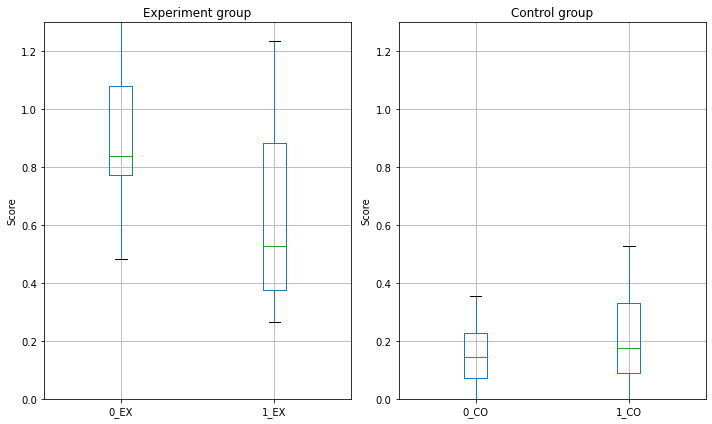

In [13]:
avg_frame_ex.index = avg_frame_ex.index.map(lambda x: str(int(x)) + "_EX")
avg_frame_co.index = avg_frame_co.index.map(lambda x: str(int(x)) + "_CO")
avg_frame_ex = avg_frame_ex.T
avg_frame_co = avg_frame_co.T

# 绘制箱线图
plt.figure(figsize=(10, 6))

# 绘制 frame1 的箱线图
plt.subplot(1, 2, 1)
avg_frame_ex.boxplot()
plt.ylim(0, 1.3)
plt.title("Experiment group")
plt.ylabel("Score")
# 绘制 frame2 的箱线图
plt.subplot(1, 2, 2)
avg_frame_co.boxplot()
plt.ylim(0, 1.3)
plt.title("Control group")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [14]:
diff_analysis(avg_frame_ex["0_EX"].tolist(), avg_frame_ex["1_EX"].tolist())
diff_analysis(avg_frame_co["0_CO"].tolist(), avg_frame_co["1_CO"].tolist())
diff_analysis(avg_frame_co["0_CO"].tolist(), avg_frame_ex["0_EX"].tolist())
diff_analysis(avg_frame_co["1_CO"].tolist(), avg_frame_ex["1_EX"].tolist())

Levene's test statistic for variance comparison: 0.6537271323740765
P-value for variance comparison: 0.42440487827271567
The statistical value of t test is STA: 3.1487806097773263 and p_value: 0.003406157650363026
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statistic for variance comparison: 0.4443615602002609
P-value for variance comparison: 0.5095233383724977
The statistical value of t test is STA: -1.2189446357056828 and p_value: 0.23125505476737276
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Levene's test statistic for variance comparison: 5.3893313770698
P-value for variance comparison: 0.026387368577894577
The statistical value of t test is STA: 0.0 and p_value: 3.1555153732145685e-07
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.
Levene's test statistic for 

BLOCK  1


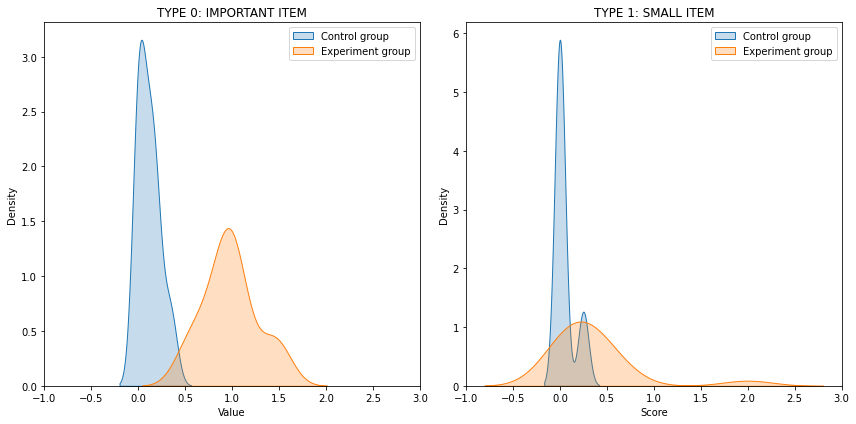

BLOCK  2


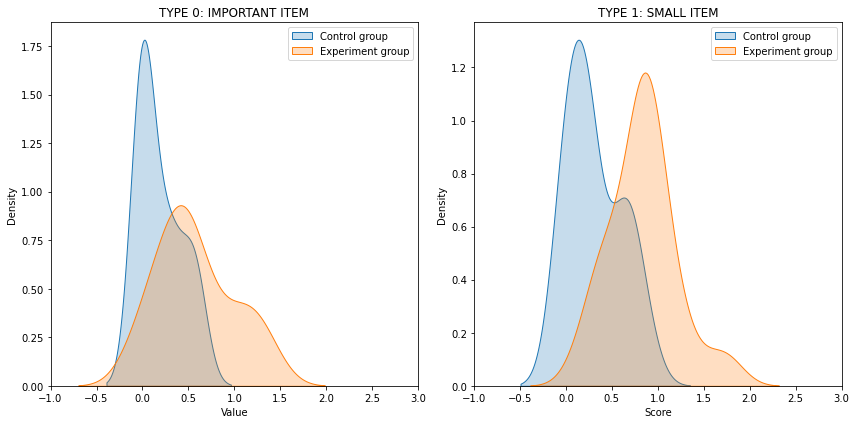

BLOCK  3


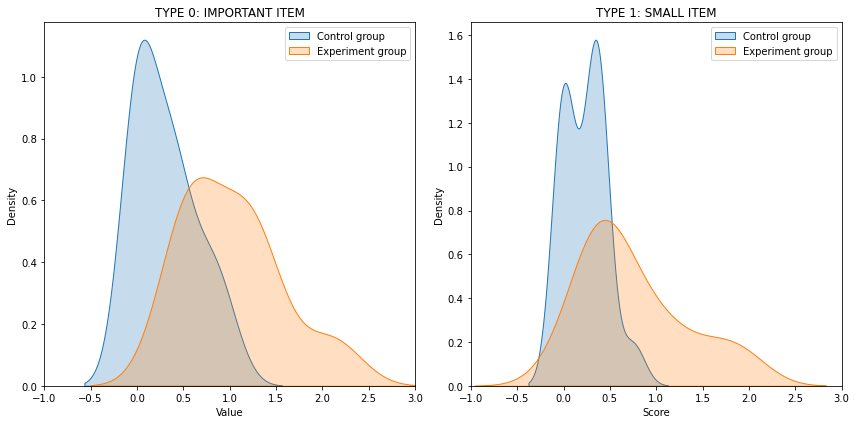

In [15]:
for idx, (df_c, df_e) in enumerate(zip(dataframes_co, dataframes_ex)):
    grouped_c = df_c.groupby("TYPE")
    grouped_e = df_e.groupby("TYPE")
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 18)]
    print("BLOCK ", idx + 1)
    # 计算每个分组中 "1~12" 列的平均值
    averages_e = grouped_e[columns_to_average].mean()
    averages_c = grouped_c[columns_to_average].mean()
    row_list_e_1 = averages_e.iloc[0].tolist()
    row_list_e_2 = averages_e.iloc[1].tolist()
    row_list_c_1 = averages_c.iloc[0].tolist()
    row_list_c_2 = averages_c.iloc[1].tolist()
    draw_kde_BLOCK(row_list_c_1, row_list_e_1, row_list_c_2, row_list_e_2)

## Edit distance

In [16]:
co_edit_json = None
ex_edit_json = None
with open('./CO/editDis.json', 'r') as json_file:
    co_edit_json = json.load(json_file)
with open('./EX/editDis.json', 'r') as json_file:
    ex_edit_json = json.load(json_file)
standard_structure = co_edit_json["standard"]
del co_edit_json["standard"]
del ex_edit_json["standard"]
del ex_edit_json["19"]
keys = ["1-1", "1-2", "2-1", "2-2", "3-1", "3-2"]
co_edit_score = []
ex_edit_score = []

for item in co_edit_json:
    tmp_arr = []
    item = co_edit_json[item]
    for key in keys:
        tmp_arr.append(Levenshtein.distance(item[key], standard_structure[key]))
    n_tmp_arr = [(tmp_arr[0] + tmp_arr[1])/(len(standard_structure["1-1"]) + len(standard_structure["1-2"])), 
                 (tmp_arr[2] + tmp_arr[3])/(len(standard_structure["2-1"]) + len(standard_structure["2-2"])), 
                 (tmp_arr[4] + tmp_arr[5])/(len(standard_structure["3-1"]) + len(standard_structure["3-2"]))]
    co_edit_score.append(n_tmp_arr)
for item in ex_edit_json:
    tmp_arr = []
    item = ex_edit_json[item]
    for key in keys:
        tmp_arr.append(Levenshtein.distance(item[key], standard_structure[key]))
    n_tmp_arr = [(tmp_arr[0] + tmp_arr[1])/(len(standard_structure["1-1"]) + len(standard_structure["1-2"])), 
                 (tmp_arr[2] + tmp_arr[3])/(len(standard_structure["2-1"]) + len(standard_structure["2-2"])), 
                 (tmp_arr[4] + tmp_arr[5])/(len(standard_structure["3-1"]) + len(standard_structure["3-2"]))]
    ex_edit_score.append(n_tmp_arr)
print(np.mean(np.array(co_edit_score)), np.mean(np.array(ex_edit_score)))
overall_co_edit_score = [np.mean(item) for item in co_edit_score]
overall_ex_edit_score = [np.mean(item) for item in ex_edit_score]

0.9382891103321211 0.7006730823935122


Levene's test statistic for variance comparison: 6.154940654638327
P-value for variance comparison: 0.018211703719904507
The statistical value of t test is STA: 317.0 and p_value: 1.0161841589588064e-06
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.
18 18


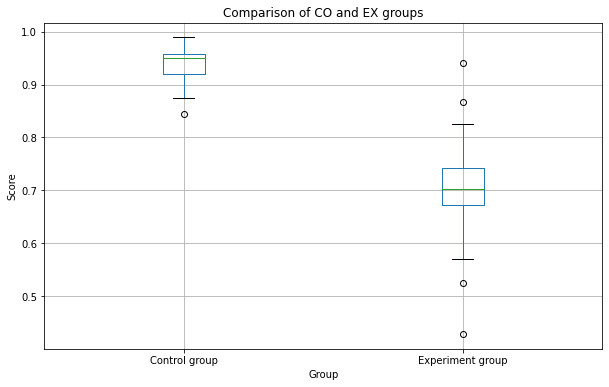

In [17]:
diff_analysis(overall_co_edit_score, overall_ex_edit_score)
print(len(overall_co_edit_score), len(overall_ex_edit_score))
df = pd.DataFrame({'Control group': overall_co_edit_score, 'Experiment group': overall_ex_edit_score})

# 使用Seaborn绘制小提琴图
plt.figure(figsize=(10, 6))
df.boxplot()
plt.xlabel('Group')
plt.ylabel('Score')
plt.title('Comparison of CO and EX groups')
plt.show()

BLOCK 1
CO:  0.9230769230769231 , EX:  0.6923076923076923
Levene's test statistic for variance comparison: 5.3947110675808085
P-value for variance comparison: 0.02631757181964451
The statistical value of t test is STA: 285.5 and p_value: 6.981483692064381e-05
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


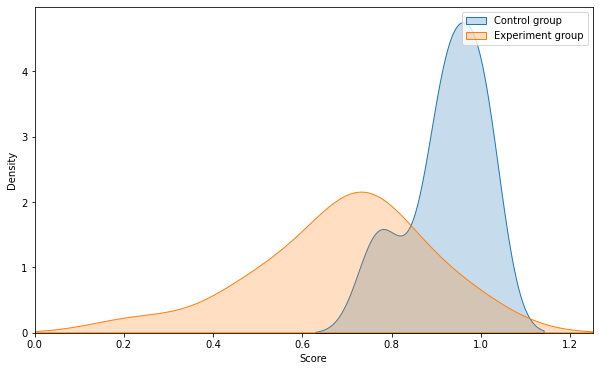



BLOCK 2
CO:  0.9605734767025091 , EX:  0.7007168458781361
Levene's test statistic for variance comparison: 6.9357899382171215
P-value for variance comparison: 0.012622894990461073
The statistical value of t test is STA: 314.0 and p_value: 1.3866679688892144e-06
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


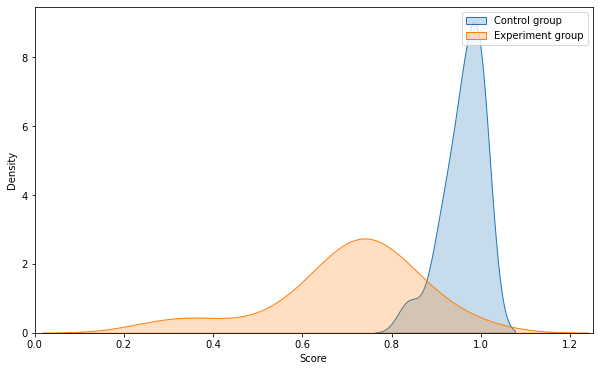



BLOCK 3
CO:  0.9312169312169313 , EX:  0.7089947089947088
Levene's test statistic for variance comparison: 1.5813953488372103
P-value for variance comparison: 0.21712906381060398
The statistical value of t test is STA: 8.154277372511274 and p_value: 1.64286526314604e-09
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


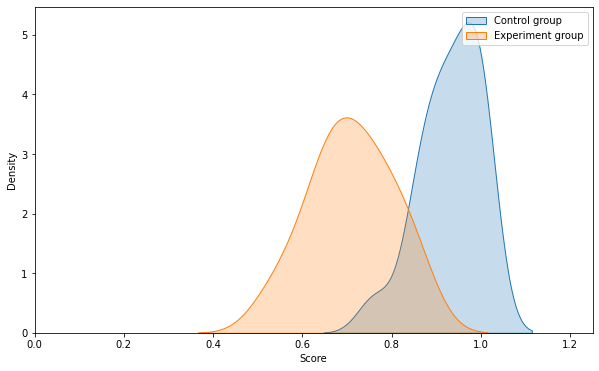

In [18]:
for i in range(3):
    array_c = [item[i] for item in co_edit_score]
    array_e = [item[i] for item in ex_edit_score]
    print("BLOCK " + str(i + 1))
    print("CO: ", np.mean(array_c), ", EX: ", np.mean(array_e))
    diff_analysis(array_c, array_e)
    # 绘制两组数据的核密度估计图
    plt.figure(figsize=(10, 6))
    sns.kdeplot(array_c, label='Control group', fill=True)
    sns.kdeplot(array_e, label='Experiment group', fill=True)
    plt.xlabel('Score')
    plt.ylabel('Density')
    # plt.title('Kernel Density Estimate of Two Data Sets')
    plt.legend()
    plt.xlim(0, 1.25)
    plt.show()
    print("\n")

## POST ANLAYSIS

In [19]:
# Variable
COLORS_IDX = [3, 6, 9, 12]
LABELS_IDX = [4, 7, 10, 13]
LAND_IDX = [5, 8, 11, 14]
OVERALL_EVA_IDX = [16, 17, 18, 21]

In [20]:
ex_colors_eva = []
co_colors_eva = []

ex_labels_eva = []
co_labels_eva = []

ex_land_eva = []
co_land_eva = []

ex_overall_eva = []
co_overall_eva = []

for item in co_json_datas:
    color = 0
    label = 0
    land = 0
    overall = 0
    for idx in COLORS_IDX:
        color += item["post"][idx]
    color /= 4
    for idx in OVERALL_EVA_IDX:
        overall += item["post"][idx]
    overall /= 4
    for idx in LABELS_IDX:
        label += item["post"][idx]
    label /= 4
    for idx in LAND_IDX:
        land += item["post"][idx]
    land /= 4
    co_colors_eva.append(color)
    co_labels_eva.append(label)
    co_land_eva.append(land)
    co_overall_eva.append(overall)

for item in ex_json_datas:
    color = 0
    label = 0
    land = 0
    overall = 0
    for idx in COLORS_IDX:
        color += item["post"][idx]
    color /= 4
    for idx in OVERALL_EVA_IDX:
        overall += item["post"][idx]
    overall /= 4
    for idx in LABELS_IDX:
        label += item["post"][idx]
    label /= 4
    for idx in LAND_IDX:
        land += item["post"][idx]
    land /= 4
    ex_colors_eva.append(color)
    ex_labels_eva.append(label)
    ex_land_eva.append(land)
    ex_overall_eva.append(overall)

In [21]:
print("COLORS: ")
print(np.mean(ex_colors_eva), np.mean(co_colors_eva))
diff_analysis(ex_colors_eva, co_colors_eva)
ConhenD(ex_colors_eva, co_colors_eva)
print("\n")
print("LABELS: ")
print(np.mean(ex_labels_eva), np.mean(co_labels_eva))
diff_analysis(ex_labels_eva, co_labels_eva)
ConhenD(ex_labels_eva, co_labels_eva)
print("\n")
print("LANDMARKS: ")
print(np.mean(ex_land_eva), np.mean(co_land_eva))
diff_analysis(ex_land_eva, co_land_eva)
ConhenD(ex_land_eva, co_land_eva)
print("\n")
print("COLORS: ")
print(np.mean(ex_overall_eva), np.mean(co_overall_eva))
diff_analysis(ex_overall_eva, co_overall_eva)
ConhenD(ex_overall_eva, co_overall_eva)
print("\n")

COLORS: 
3.888888888888889 3.736111111111111
Levene's test statistic for variance comparison: 0.7799949161159123
P-value for variance comparison: 0.38334492290966315
The statistical value of t test is STA: 0.28475114010995917 and p_value: 0.7775620859766909
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Cohen's d: 0.09491704670331971


LABELS: 
5.333333333333333 4.972222222222222
Levene's test statistic for variance comparison: 0.24839275277615452
P-value for variance comparison: 0.621417992327842
The statistical value of t test is STA: 0.8331440551733488 and p_value: 0.4105781737735632
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Cohen's d: 0.2777146850577829


LANDMARKS: 
5.75 5.111111111111111
Levene's test statistic for variance comparison: 1.2815076560659602
P-value for variance comparison: 0.2655399209988101
The statistical value of t t

### How do you like each element you saw

正态性检验结果:
COLOR: 0.3167244493961334
LABEL: 0.0637122243642807
LANDMARK: 0.010444600135087967

方差齐性检验结果:
Levene检验p值: 0.43337993746546233

多因素ANOVA结果:
ANOVA p值: 0.267767484853145

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   0.4444 0.5328 -0.5521  1.441  False
 COLOR LANDMARK   0.6667 0.2487 -0.3299 1.6632  False
 LABEL LANDMARK   0.2222 0.8529 -0.7743 1.2188  False
-----------------------------------------------------


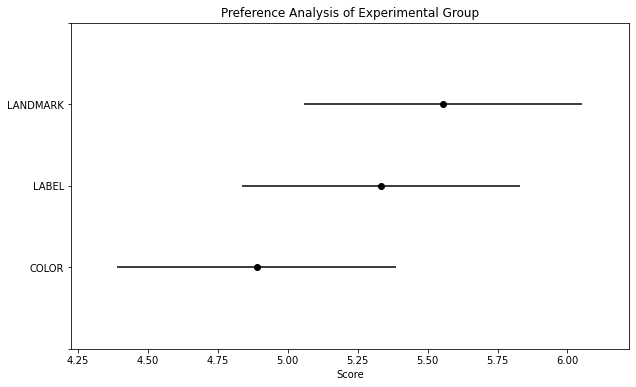

平均分数:
COLOR: 4.89
LABEL: 5.33
LANDMARK: 5.56

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.008385957218706608
LABEL: 0.007670441176742315
LANDMARK: 0.009566319175064564

方差齐性检验结果:
Levene检验p值: 0.09181008095157481

多因素ANOVA结果:
ANOVA p值: 0.1499487252145847

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL      1.0 0.1763 -0.3332 2.3332  False
 COLOR LANDMARK   0.8889 0.2509 -0.4443 2.2221  False
 LABEL LANDMARK  -0.1111 0.9779 -1.4443 1.2221  False
-----------------------------------------------------


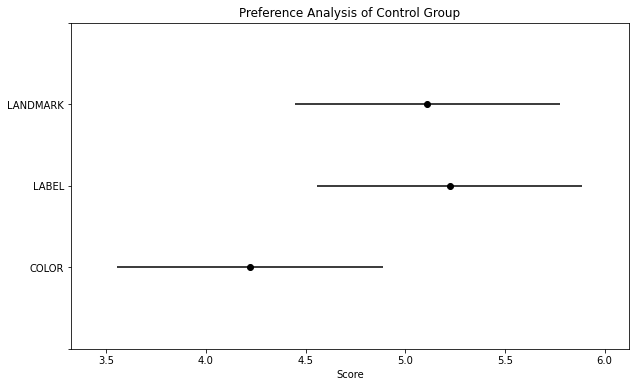

平均分数:
COLOR: 4.22
LABEL: 5.22
LANDMARK: 5.11

用户辅助最大的方面是：LABEL


In [22]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][3])
    CO_LABELS.append(item["post"][4])
    CO_LANDMARKS.append(item["post"][5])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][3])
    EX_LABELS.append(item["post"][4])
    EX_LANDMARKS.append(item["post"][5])
'''    
print("颜色方面：")
print(np.mean(EX_COLORS), np.mean(CO_COLORS))
diff_analysis(EX_COLORS, CO_COLORS)
ConhenD(EX_COLORS, CO_COLORS)
print("\n标签设计方面：")
print(np.mean(EX_LABELS), np.mean(CO_LABELS))
diff_analysis(EX_LABELS, CO_LABELS)
ConhenD(EX_LABELS, CO_LABELS)
print("\n地标设计方面：")
print(np.mean(EX_LANDMARKS), np.mean(CO_LANDMARKS))
diff_analysis(EX_LANDMARKS, CO_LANDMARKS)
ConhenD(EX_LANDMARKS, CO_LANDMARKS)
'''
n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Preference Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Preference Analysis of Control Group")

### How do you think each element helps you remember the area

正态性检验结果:
COLOR: 0.12739047408103943
LABEL: 0.005813267081975937
LANDMARK: 0.0004235154774505645

方差齐性检验结果:
Levene检验p值: 0.16375065502795133

多因素ANOVA结果:
ANOVA p值: 2.1757491371177683e-05

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.7778  0.001  0.6592 2.8964   True
 COLOR LANDMARK   2.2778    0.0  1.1592 3.3964   True
 LABEL LANDMARK      0.5 0.5313 -0.6186 1.6186  False
-----------------------------------------------------


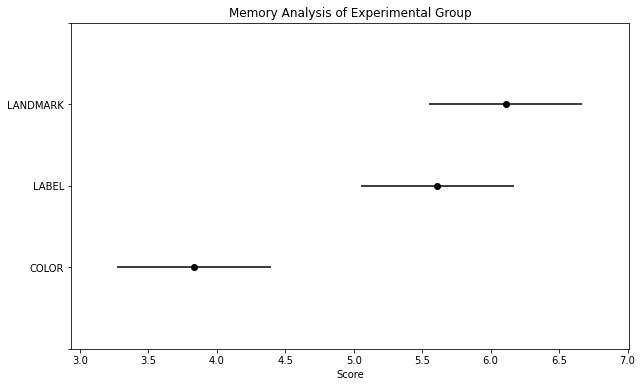

平均分数:
COLOR: 3.83
LABEL: 5.61
LANDMARK: 6.11

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.06018560007214546
LABEL: 0.15532700717449188
LANDMARK: 0.0025622297544032335

方差齐性检验结果:
Levene检验p值: 0.026236065121891933

多因素ANOVA结果:
ANOVA p值: 0.0224581538167509

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.2778 0.0629 -0.0557 2.6112  False
 COLOR LANDMARK   1.4444 0.0309   0.111 2.7779   True
 LABEL LANDMARK   0.1667 0.9511 -1.1668 1.5001  False
-----------------------------------------------------


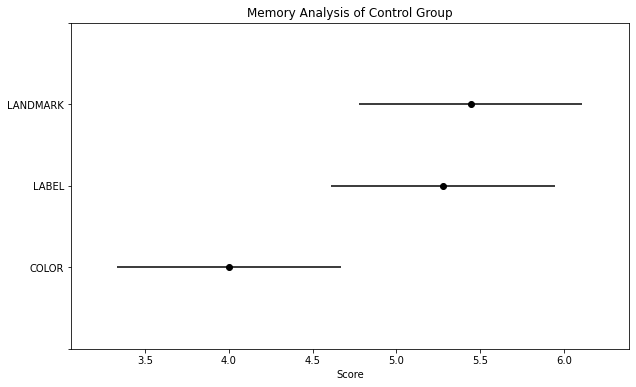

平均分数:
COLOR: 4.00
LABEL: 5.28
LANDMARK: 5.44

用户辅助最大的方面是：LANDMARK


In [23]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][6])
    CO_LABELS.append(item["post"][7])
    CO_LANDMARKS.append(item["post"][8])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][6])
    EX_LABELS.append(item["post"][7])
    EX_LANDMARKS.append(item["post"][8])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Memory Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Memory Analysis of Control Group")

### How do you think each element helps you locate your position

正态性检验结果:
COLOR: 0.050474733114242554
LABEL: 0.003913499880582094
LANDMARK: 0.0015687568811699748

方差齐性检验结果:
Levene检验p值: 0.25714052878972027

多因素ANOVA结果:
ANOVA p值: 4.149938854691224e-06

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   2.0556 0.0004  0.8616 3.2495   True
 COLOR LANDMARK   2.6667    0.0  1.4727 3.8606   True
 LABEL LANDMARK   0.6111  0.438 -0.5828  1.805  False
-----------------------------------------------------


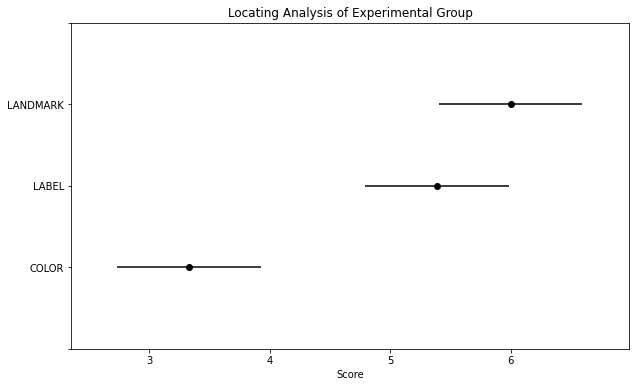

平均分数:
COLOR: 3.33
LABEL: 5.39
LANDMARK: 6.00

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.03097776509821415
LABEL: 0.1793205291032791
LANDMARK: 0.0034431705716997385

方差齐性检验结果:
Levene检验p值: 0.5447066115894095

多因素ANOVA结果:
ANOVA p值: 0.0040524008832393986

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.3333 0.0578 -0.0356 2.7023  False
 COLOR LANDMARK   1.9444 0.0034  0.5755 3.3134   True
 LABEL LANDMARK   0.6111 0.5322 -0.7578 1.9801  False
-----------------------------------------------------


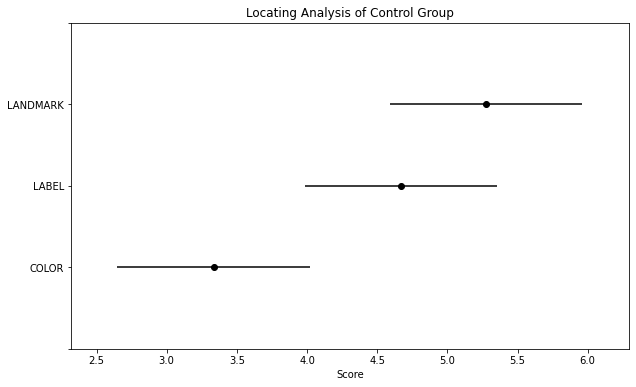

平均分数:
COLOR: 3.33
LABEL: 4.67
LANDMARK: 5.28

用户辅助最大的方面是：LANDMARK


In [24]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][9])
    CO_LABELS.append(item["post"][10])
    CO_LANDMARKS.append(item["post"][11])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][9])
    EX_LABELS.append(item["post"][10])
    EX_LANDMARKS.append(item["post"][11])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Locating Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Locating Analysis of Control Group")

### How do you think each element helps you identify your orientation

正态性检验结果:
COLOR: 0.12800057232379913
LABEL: 0.0240633524954319
LANDMARK: 0.005030846688896418

方差齐性检验结果:
Levene检验p值: 0.707510651287494

多因素ANOVA结果:
ANOVA p值: 0.00929513380844915

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL      1.5 0.0448  0.0287 2.9713   True
 COLOR LANDMARK   1.8333 0.0112  0.3621 3.3046   True
 LABEL LANDMARK   0.3333 0.8485 -1.1379 1.8046  False
-----------------------------------------------------


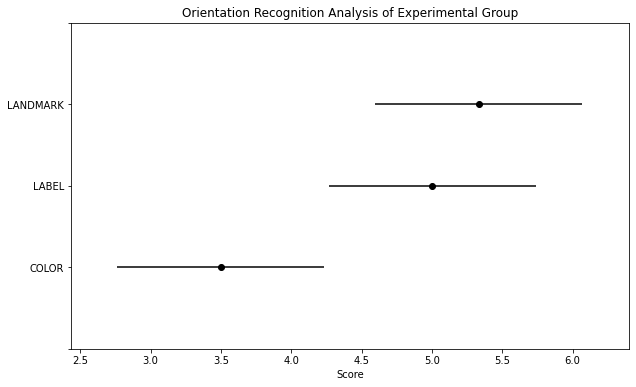

平均分数:
COLOR: 3.50
LABEL: 5.00
LANDMARK: 5.33

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.13796009123325348
LABEL: 0.044774994254112244
LANDMARK: 0.06884624809026718

方差齐性检验结果:
Levene检验p值: 0.9461448648622856

多因素ANOVA结果:
ANOVA p值: 0.09964256743927083

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 COLOR    LABEL   1.3333 0.1275 -0.2923  2.959  False
 COLOR LANDMARK   1.2222 0.1749 -0.4034 2.8479  False
 LABEL LANDMARK  -0.1111 0.9851 -1.7368 1.5146  False
-----------------------------------------------------


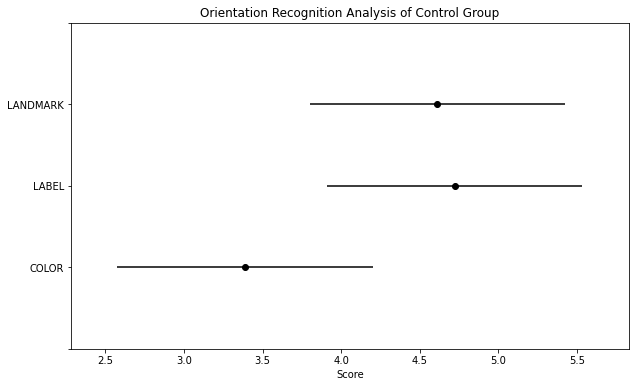

平均分数:
COLOR: 3.39
LABEL: 4.72
LANDMARK: 4.61

用户辅助最大的方面是：LABEL


In [25]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][12])
    CO_LABELS.append(item["post"][13])
    CO_LANDMARKS.append(item["post"][14])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][12])
    EX_LABELS.append(item["post"][13])
    EX_LANDMARKS.append(item["post"][14])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Orientation Recognition Analysis of Experimental Group")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Orientation Recognition Analysis of Control Group")

### COLORS

正态性检验结果:
喜好程度: 0.3167244493961334
辅助记忆区域: 0.12739047408103943
辅助定位: 0.050474733114242554
辅助认知朝向: 0.12800057232379913

方差齐性检验结果:
Levene检验p值: 0.4267373093852759

多因素ANOVA结果:
ANOVA p值: 0.036389124569401576

存在显著差异，可以进行事后分析。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY      0.5 0.8166  -1.001  2.001  False
   LOCATING ORIENTATION   0.1667 0.9912 -1.3343 1.6677  False
   LOCATING  PREFERENCE   1.5556 0.0394  0.0546 3.0565   True
     MEMORY ORIENTATION  -0.3333 0.9363 -1.8343 1.1677  False
     MEMORY  PREFERENCE   1.0556 0.2584 -0.4454 2.5565  False
ORIENTATION  PREFERENCE   1.3889 0.0797 -0.1121 2.8899  False
-------------------------------------------------------------


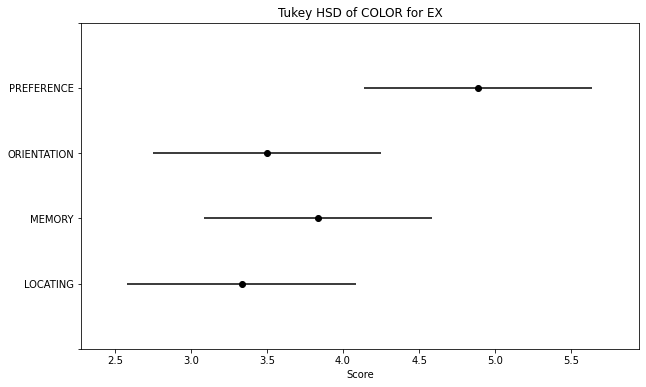

平均分数:
喜好程度: 4.89
辅助记忆区域: 3.83
辅助定位: 3.33
辅助认知朝向: 3.50

用户辅助最大的方面是：喜好程度
正态性检验结果:
喜好程度: 0.008385957218706608
辅助记忆区域: 0.06018560007214546
辅助定位: 0.03097776509821415
辅助认知朝向: 0.13796009123325348

方差齐性检验结果:
Levene检验p值: 0.903533958824377

多因素ANOVA结果:
ANOVA p值: 0.4566342290887968

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.6667 0.7513 -1.0936  2.427  False
   LOCATING ORIENTATION   0.0556 0.9998 -1.7047 1.8158  False
   LOCATING  PREFERENCE   0.8889 0.5473 -0.8714 2.6492  False
     MEMORY ORIENTATION  -0.6111 0.7973 -2.3714 1.1492  False
     MEMORY  PREFERENCE   0.2222 0.9872 -1.5381 1.9825  False
ORIENTATION  PREFERENCE   0.8333 0.5996  -0.927 2.5936  False
-------------------------------------------------------------


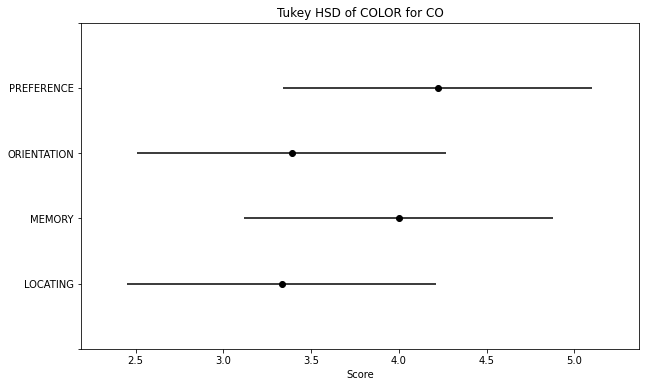

平均分数:
喜好程度: 4.22
辅助记忆区域: 4.00
辅助定位: 3.33
辅助认知朝向: 3.39

用户辅助最大的方面是：喜好程度


In [26]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][3])
    CO_REMEMBER.append(item["post"][6])
    CO_LOCATION.append(item["post"][9])
    CO_ORIENTATION.append(item["post"][12])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][3])
    EX_REMEMBER.append(item["post"][6])
    EX_LOCATION.append(item["post"][9])
    EX_ORIENTATION.append(item["post"][12])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of COLOR for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of COLOR for CO")

### LABELS

正态性检验结果:
喜好程度: 0.0637122243642807
辅助记忆区域: 0.005813267081975937
辅助定位: 0.003913499880582094
辅助认知朝向: 0.0240633524954319

方差齐性检验结果:
Levene检验p值: 0.8060420508805002

多因素ANOVA结果:
ANOVA p值: 0.7050467350612328

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.2222 0.9738 -1.1517 1.5962  False
   LOCATING ORIENTATION  -0.3889 0.8783 -1.7628 0.9851  False
   LOCATING  PREFERENCE  -0.0556 0.9996 -1.4295 1.3184  False
     MEMORY ORIENTATION  -0.6111 0.6468 -1.9851 0.7628  False
     MEMORY  PREFERENCE  -0.2778 0.9509 -1.6517 1.0962  False
ORIENTATION  PREFERENCE   0.3333  0.919 -1.0406 1.7073  False
-------------------------------------------------------------


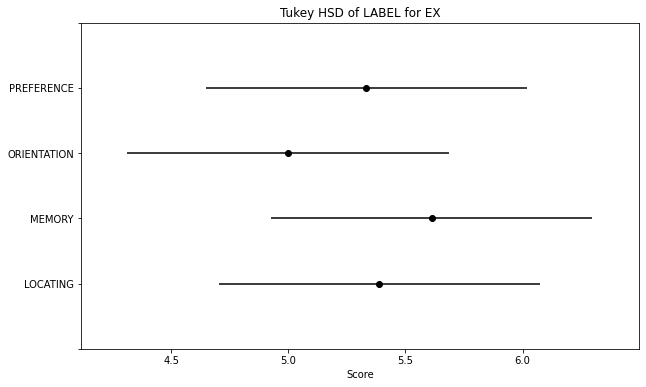

平均分数:
喜好程度: 5.33
辅助记忆区域: 5.61
辅助定位: 5.39
辅助认知朝向: 5.00

用户辅助最大的方面是：辅助记忆区域
正态性检验结果:
喜好程度: 0.007670441176742315
辅助记忆区域: 0.15532700717449188
辅助定位: 0.1793205291032791
辅助认知朝向: 0.044774994254112244

方差齐性检验结果:
Levene检验p值: 0.07753636179905977

多因素ANOVA结果:
ANOVA p值: 0.5280177319658442

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.6111 0.6549 -0.7783 2.0006  False
   LOCATING ORIENTATION   0.0556 0.9996 -1.3339  1.445  False
   LOCATING  PREFERENCE   0.5556 0.7189 -0.8339  1.945  False
     MEMORY ORIENTATION  -0.5556 0.7189  -1.945 0.8339  False
     MEMORY  PREFERENCE  -0.0556 0.9996  -1.445 1.3339  False
ORIENTATION  PREFERENCE      0.5 0.7792 -0.8895 1.8895  False
-------------------------------------------------------------


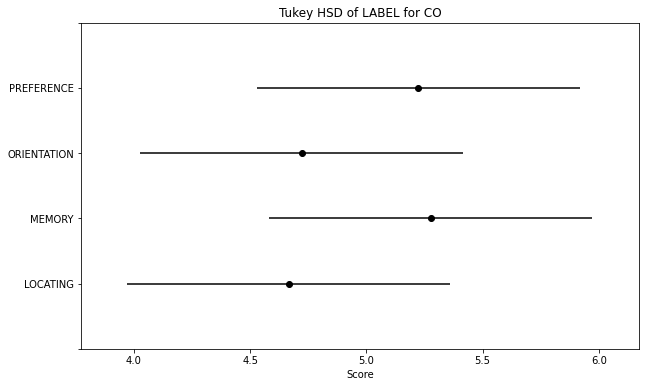

平均分数:
喜好程度: 5.22
辅助记忆区域: 5.28
辅助定位: 4.67
辅助认知朝向: 4.72

用户辅助最大的方面是：辅助记忆区域


In [27]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][4])
    CO_REMEMBER.append(item["post"][7])
    CO_LOCATION.append(item["post"][10])
    CO_ORIENTATION.append(item["post"][13])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][4])
    EX_REMEMBER.append(item["post"][7])
    EX_LOCATION.append(item["post"][10])
    EX_ORIENTATION.append(item["post"][13])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of LABEL for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of LABEL for CO")

### LANDMARKS

正态性检验结果:
喜好程度: 0.010444600135087967
辅助记忆区域: 0.0004235154774505645
辅助定位: 0.0015687568811699748
辅助认知朝向: 0.005030846688896418

方差齐性检验结果:
Levene检验p值: 0.05596610200019469

多因素ANOVA结果:
ANOVA p值: 0.1648918015079518

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.1111  0.992 -0.9223 1.1445  False
   LOCATING ORIENTATION  -0.6667 0.3322 -1.7001 0.3667  False
   LOCATING  PREFERENCE  -0.4444 0.6708 -1.4778  0.589  False
     MEMORY ORIENTATION  -0.7778 0.2048 -1.8112 0.2556  False
     MEMORY  PREFERENCE  -0.5556  0.494  -1.589 0.4778  False
ORIENTATION  PREFERENCE   0.2222 0.9417 -0.8112 1.2556  False
-------------------------------------------------------------


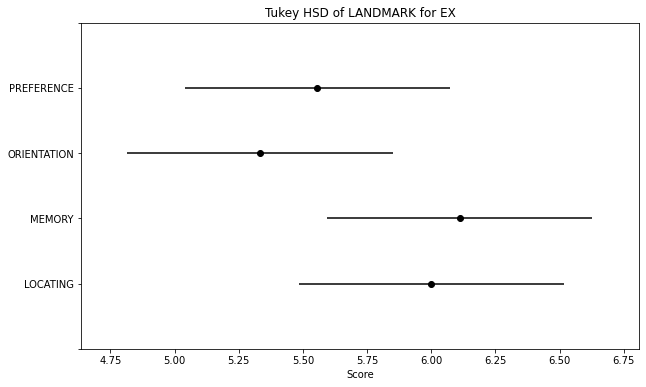

平均分数:
喜好程度: 5.56
辅助记忆区域: 6.11
辅助定位: 6.00
辅助认知朝向: 5.33

用户辅助最大的方面是：辅助记忆区域
正态性检验结果:
喜好程度: 0.009566319175064564
辅助记忆区域: 0.0025622297544032335
辅助定位: 0.0034431705716997385
辅助认知朝向: 0.06884624809026718

方差齐性检验结果:
Levene检验p值: 0.40172747543973497

多因素ANOVA结果:
ANOVA p值: 0.48413977587066515

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.1667 0.9908 -1.3089 1.6423  False
   LOCATING ORIENTATION  -0.6667 0.6353 -2.1423 0.8089  False
   LOCATING  PREFERENCE  -0.1667 0.9908 -1.6423 1.3089  False
     MEMORY ORIENTATION  -0.8333 0.4507 -2.3089 0.6423  False
     MEMORY  PREFERENCE  -0.3333 0.9333 -1.8089 1.1423  False
ORIENTATION  PREFERENCE      0.5 0.8088 -0.9756 1.9756  False
-------------------------------------------------------------


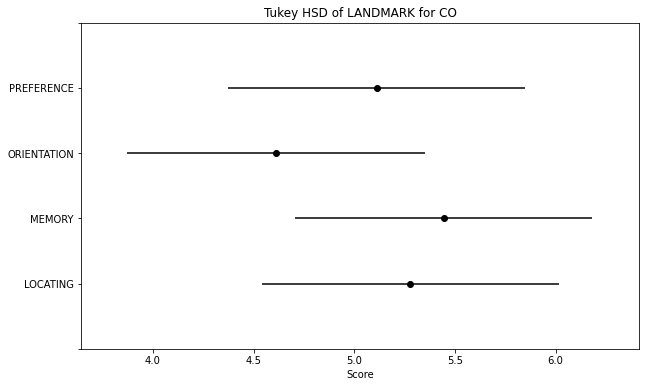

平均分数:
喜好程度: 5.11
辅助记忆区域: 5.44
辅助定位: 5.28
辅助认知朝向: 4.61

用户辅助最大的方面是：辅助记忆区域


In [28]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][5])
    CO_REMEMBER.append(item["post"][8])
    CO_LOCATION.append(item["post"][11])
    CO_ORIENTATION.append(item["post"][14])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][5])
    EX_REMEMBER.append(item["post"][8])
    EX_LOCATION.append(item["post"][11])
    EX_ORIENTATION.append(item["post"][14])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of LANDMARK for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of LANDMARK for CO")

In [29]:
CO_MAP = []
CO_AR = []
EX_MAP = []
EX_AR = []
for item in co_json_datas:
    CO_MAP.append(item["post"][22])
    CO_AR.append(item["post"][23])
    
for item in ex_json_datas:
    EX_MAP.append(item["post"][22])
    EX_AR.append(item["post"][23])
print(np.mean(CO_MAP), np.mean(CO_AR))
diff_analysis(CO_MAP, CO_AR)
print("\n")
print(np.mean(EX_MAP), np.mean(EX_AR))
diff_analysis(EX_MAP, EX_AR)
print("\n")
diff_analysis(CO_AR, EX_AR)

4.277777777777778 5.666666666666667
Levene's test statistic for variance comparison: 3.5404475043029264
P-value for variance comparison: 0.06847367010532898
The statistical value of t test is STA: -2.6570285403909066 and p_value: 0.011920885624554312
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


4.555555555555555 5.611111111111111
Levene's test statistic for variance comparison: 2.5081967213114744
P-value for variance comparison: 0.1225141627996641
The statistical value of t test is STA: -2.227374338320183 and p_value: 0.03264748869438117
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


Levene's test statistic for variance comparison: 0.0389016018306635
P-value for variance comparison: 0.8448181131810487
The statistical value of t test is STA: 0.14285714285714465 and p_value: 0.8872462741561994
Fail to reject the null hypothesis using Student's t-test: There 

In [30]:
ex_0_score = avg_frame_ex["0_EX"].to_list()
ex_1_score = avg_frame_ex["1_EX"].to_list()
co_0_score = avg_frame_co["0_CO"].to_list()
co_1_score = avg_frame_co["1_CO"].to_list()

[18, 18, 18, 18]


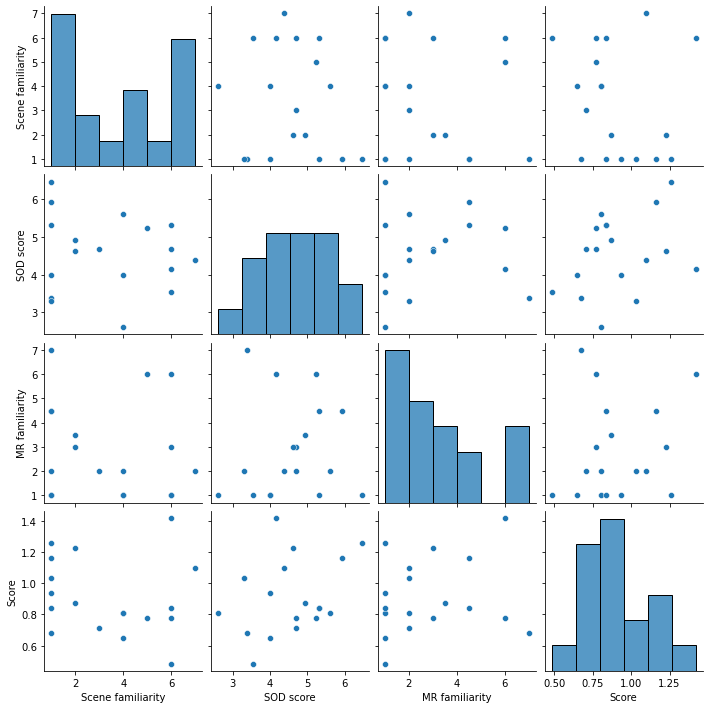

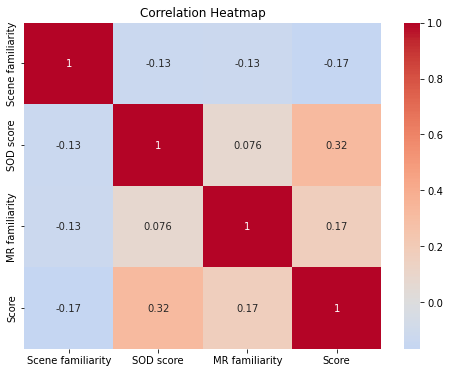

Linear Regression:
Mean Squared Error: 0.06427036080923018
R-squared: -2.1372097390562663

Polynomial Regression:
Mean Squared Error: 0.03273983546451653
R-squared: -0.5981197146108144

Ridge Regression:
Mean Squared Error: 0.06259114171252009
R-squared: -2.0552425237197127

Lasso Regression:
Mean Squared Error: 0.03216739139648316
R-squared: -0.5701771749597633

Decision Tree Regression:
Mean Squared Error: 0.05879292403746101
R-squared: -1.8698412698412734


In [31]:
print(list(map(lambda x: len(x), [ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score])))
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score)


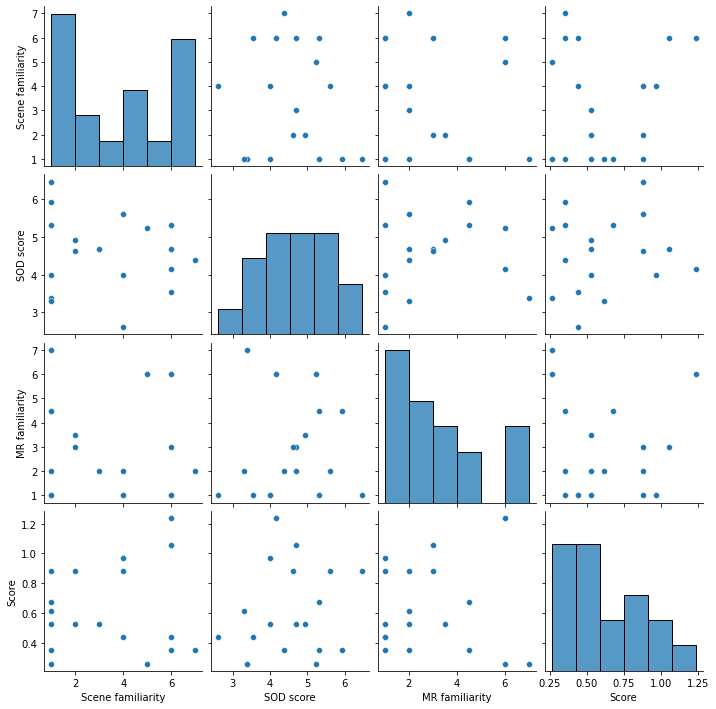

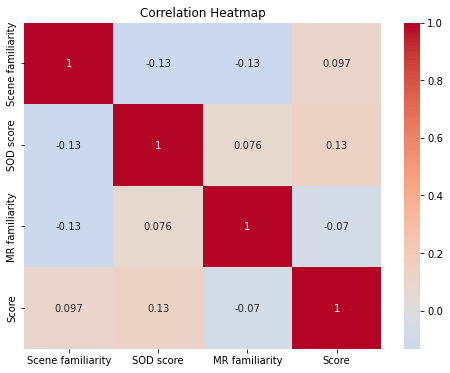

Linear Regression:
Mean Squared Error: 0.056669297523755
R-squared: -0.49950690557850175

Polynomial Regression:
Mean Squared Error: 0.09870712317757964
R-squared: -1.611855436756099

Ridge Regression:
Mean Squared Error: 0.05642399260376252
R-squared: -0.49301597596450897

Lasso Regression:
Mean Squared Error: 0.042874634006191195
R-squared: -0.13449103087054715

Decision Tree Regression:
Mean Squared Error: 0.2519463667820069
R-squared: -5.666666666666667


In [32]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_1_score)

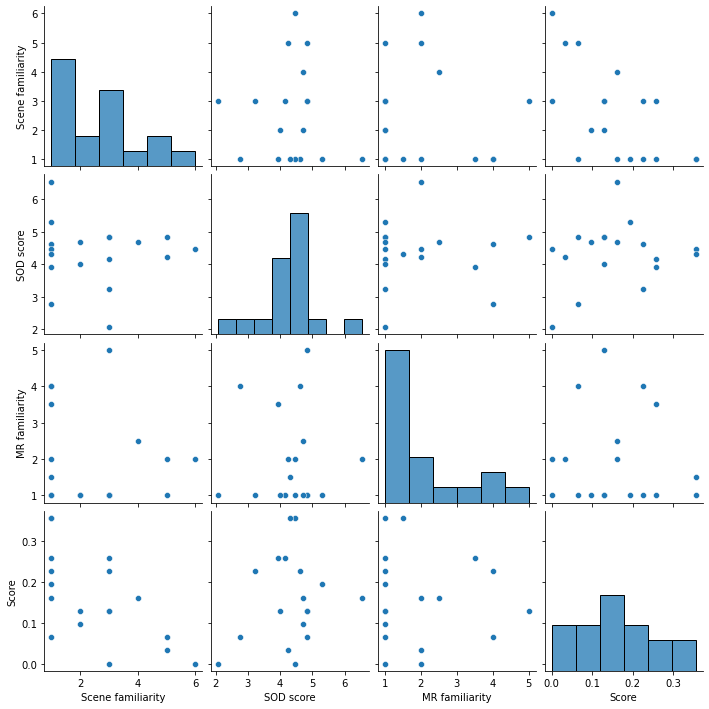

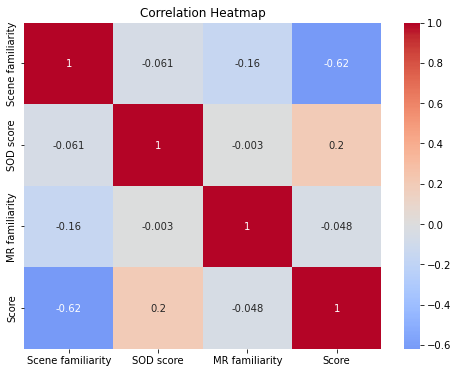

Linear Regression:
Mean Squared Error: 0.006082883003083607
R-squared: 0.055248393379661254

Polynomial Regression:
Mean Squared Error: 0.032508094682123394
R-squared: -4.048933978104336

Ridge Regression:
Mean Squared Error: 0.006099540106652236
R-squared: 0.05266132646581034

Lasso Regression:
Mean Squared Error: 0.009625390218522371
R-squared: -0.4949494949494946

Decision Tree Regression:
Mean Squared Error: 0.021071800208116543
R-squared: -2.272727272727272


In [33]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_0_score)

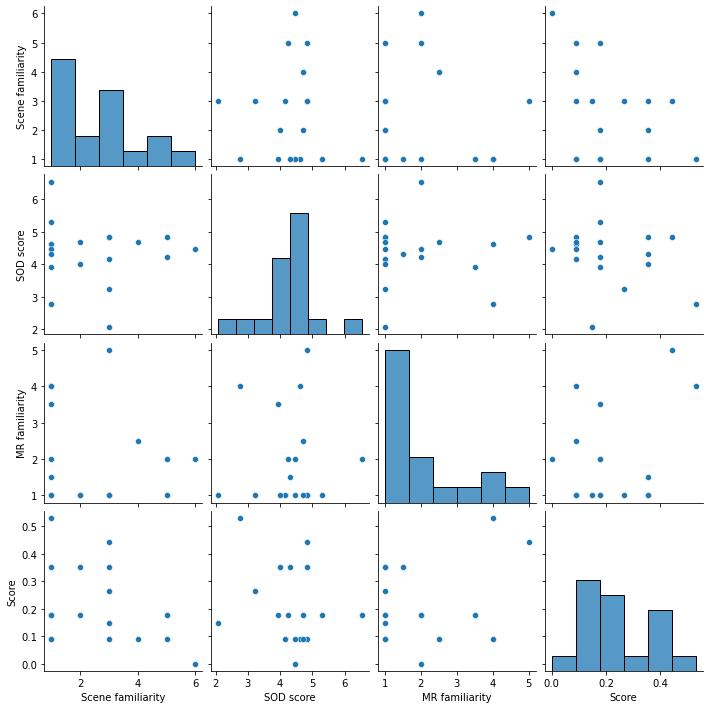

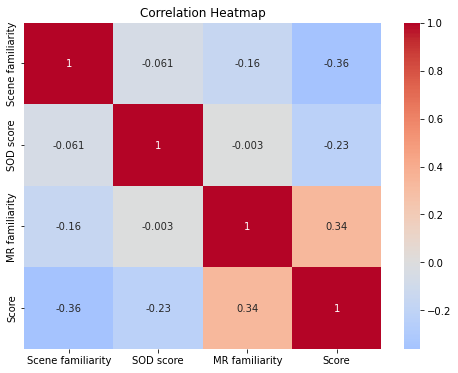

Linear Regression:
Mean Squared Error: 0.049579456758487836
R-squared: -32.9637641557404

Polynomial Regression:
Mean Squared Error: 0.34599065293610703
R-squared: -236.01641172986055

Ridge Regression:
Mean Squared Error: 0.04671273097817564
R-squared: -30.999950821197647

Lasso Regression:
Mean Squared Error: 0.017614398700656727
R-squared: -11.066515495086918

Decision Tree Regression:
Mean Squared Error: 0.09731833910034601
R-squared: -65.66666666666664


In [34]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_1_score)

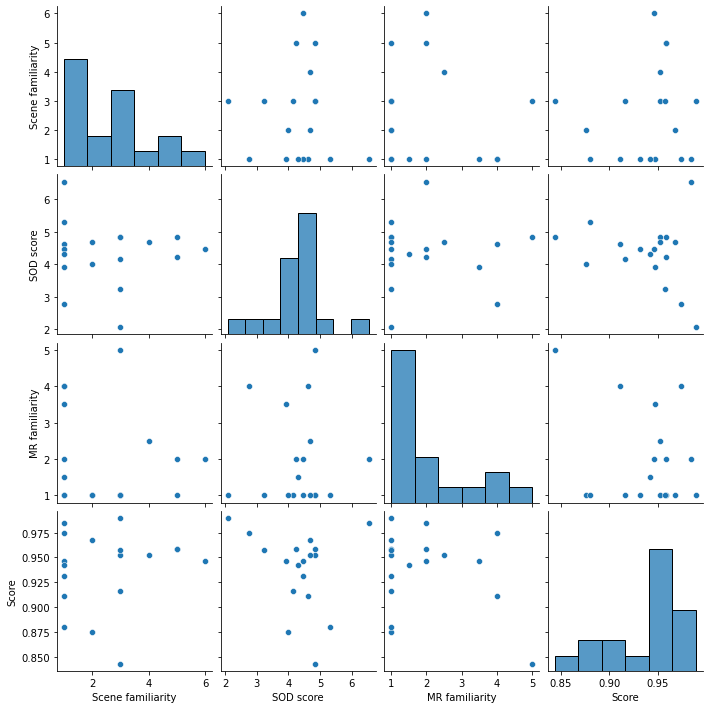

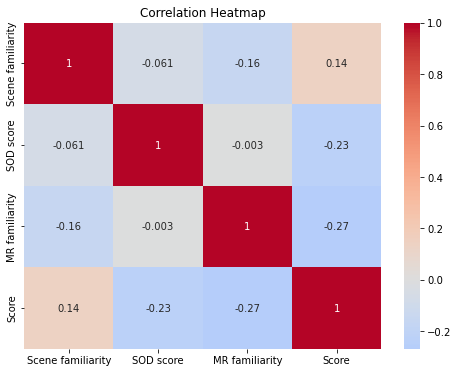

Linear Regression:
Mean Squared Error: 0.00044956634591168665
R-squared: -0.12596515909144745

Polynomial Regression:
Mean Squared Error: 0.00176374558794484
R-squared: -3.4174037927591367

Ridge Regression:
Mean Squared Error: 0.00043682091936505217
R-squared: -0.09404349422534852

Lasso Regression:
Mean Squared Error: 0.0004430944303045291
R-squared: -0.10975586862184672

Decision Tree Regression:
Mean Squared Error: 0.0009054670398356227
R-squared: -1.2677950625798302


In [35]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, overall_co_edit_score)

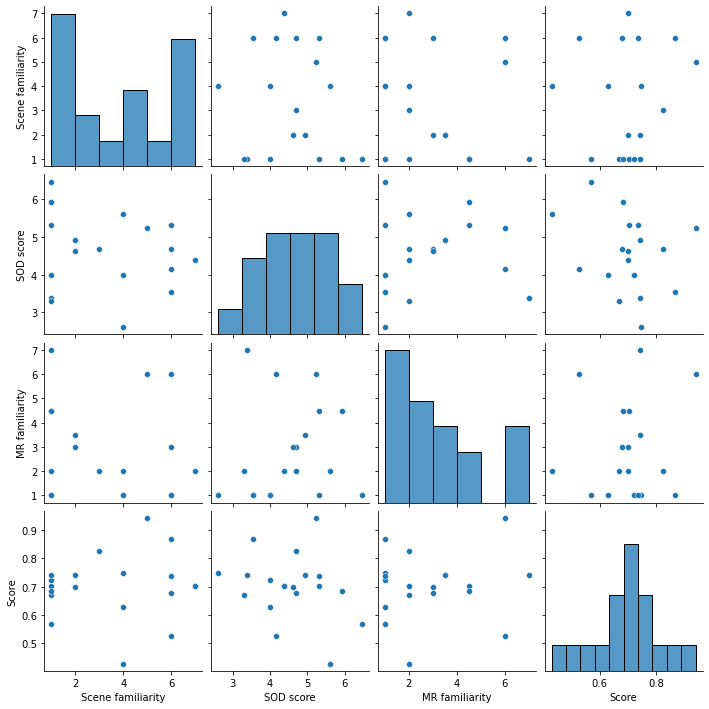

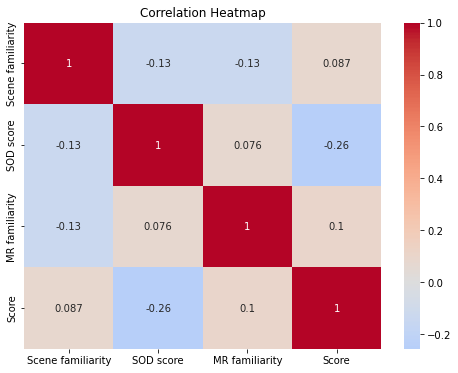

Linear Regression:
Mean Squared Error: 0.022411939774614517
R-squared: -0.05927670445254085

Polynomial Regression:
Mean Squared Error: 0.02495984488556847
R-squared: -0.1797007532555861

Ridge Regression:
Mean Squared Error: 0.022517433499925174
R-squared: -0.06426275415690719

Lasso Regression:
Mean Squared Error: 0.023298432603853555
R-squared: -0.10117585339371216

Decision Tree Regression:
Mean Squared Error: 0.029099391575711668
R-squared: -0.37535206322515013


In [36]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, overall_ex_edit_score)

In [37]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score)

Spearman Correlation and p-value for scene familiarity: -0.2234116321120348 0.37285010571880495
Spearman Correlation and p-value for sod: 0.291407867494824 0.24069046003875666
Spearman Correlation and p-value for mr familiarity: 0.13040274490039236 0.6060327452716312


In [38]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_1_score)

Spearman Correlation and p-value for scene familiarity: 0.01601149254830465 0.9497205327540592
Spearman Correlation and p-value for sod: 0.06767419643390415 0.789615259468786
Spearman Correlation and p-value for mr familiarity: -0.10929300436918621 0.6659600019153132


In [39]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, overall_ex_edit_score)

Spearman Correlation and p-value for scene familiarity: 0.08795457778223947 0.7285584949208178
Spearman Correlation and p-value for sod: -0.2480623136379577 0.32094837327525205
Spearman Correlation and p-value for mr familiarity: 0.03069773228404317 0.9037566949251249


In [40]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_0_score)

Spearman Correlation and p-value for scene familiarity: -0.595537574360528 0.009114482307595583
Spearman Correlation and p-value for sod: 0.03798135176437328 0.8810598435168212
Spearman Correlation and p-value for mr familiarity: -0.036680345098825035 0.8851080078820911


In [41]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_1_score)

Spearman Correlation and p-value for scene familiarity: -0.3238453101031183 0.1898617812294676
Spearman Correlation and p-value for sod: -0.12078717984058522 0.6330622277366935
Spearman Correlation and p-value for mr familiarity: 0.14147116285414205 0.5755132538820091


In [42]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, overall_co_edit_score)

Spearman Correlation and p-value for scene familiarity: 0.16043892291407047 0.5248035812222717
Spearman Correlation and p-value for sod: -0.17711089927457185 0.4820172181848418
Spearman Correlation and p-value for mr familiarity: -0.07301885752668531 0.7733952750005246


## Fire extinguisher evaluation

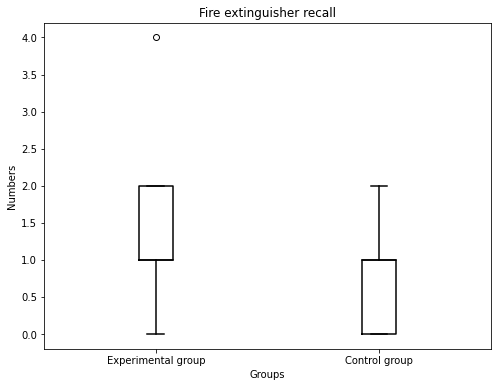

In [43]:
fire_co = [co_edit_json[item]["fire"] for item in co_edit_json]
fire_ex = [ex_edit_json[item]["fire"] for item in ex_edit_json]


# 使用Seaborn绘制箱线图
plt.figure(figsize=(8, 6))
boxprops = dict(linewidth=1.5, color='black')  # 箱体边框样式
whiskerprops = dict(linewidth=1.5, color='black')  # 须的样式
medianprops = dict(linewidth=1.5, color='black')  # 中位数线的样式
capprops = dict(linewidth=1.5, color='black')  # 顶部和底部线的样式

plt.boxplot([fire_ex, fire_co], boxprops=boxprops, whiskerprops=whiskerprops,
            medianprops=medianprops, capprops=capprops)
plt.xticks([1, 2], ['Experimental group', 'Control group'])
plt.title('Fire extinguisher recall')  # 添加标题
plt.xlabel('Groups')  # 添加x轴标签
plt.ylabel('Numbers')  # 添加y轴标签
plt.show()

In [44]:
print(np.mean(fire_co), np.mean(fire_ex))
diff_analysis(fire_co, fire_ex)

0.6111111111111112 1.2777777777777777
Levene's test statistic for variance comparison: 0.25563909774436117
P-value for variance comparison: 0.6163944594086705
The statistical value of t test is STA: -2.492628726774837 and p_value: 0.017713524205210465
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
